## Fit a FCHL Model
We want to train a model based on the the FCHL representation. [In the paper](https://aip.scitation.org/doi/10.1063/1.5020710), the authors claim that you do not need to tune any of the kernel hyperparameters, so we just use the ones computed in the previous notebook. However, we will still fit the regularization parameter

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline
from jcesr_ml.qml import FCHLKernel
from ase.units import Hartree, eV
from time import perf_counter
from tqdm import tqdm
import pickle as pkl
import pandas as pd
import numpy as np
import gzip

## Load in the Training Data
Load the training data, complete with the representations

In [2]:
train_data = pd.read_pickle('train_data.pkl.gz')

In [3]:
test_data = pd.read_pickle('test_data.pkl.gz')

## Make a Fitting Pipeline
Faber et al. use a Kernel Ridge regression model to fit molecular energies. The kernel function is a bit complex and uses their `qml` library. So, we are not going to the [KernelRidge](https://scikit-learn.org/stable/modules/generated/sklearn.kernel_ridge.KernelRidge.html) class in scikit-learn because that would inefficiently compute the representation point-by-point. 
Rather, we will leverage the parallelized version available in `qml` to compute the kernel matrix and then a scikit-learn ridge regression (not KRR) to compute the linear model. Breaking the calculation into these two steps is equivalent to KRR. 

As the regularization parameter is so small, we elect to simply use linear regression.

Make the pipeline for training the model

In [4]:
model = Pipeline([
    ('kernel', FCHLKernel()),
    ('ridge_regression', LinearRegression(fit_intercept=False))
])

## Compare our Results to FCHL Paper
Run the computation for `u0` and compare to the reports in FCHL. We will fit to the atomization energies

In [5]:
results = []
for train_size in tqdm([10, 100, 1000, 10000]):
    # Get some training data
    train_subset = train_data.sample(train_size)
    
    # Train the model
    train_time = perf_counter()
    model.fit(train_subset['rep'].tolist(), train_subset['u0_atomization'])
    train_time = perf_counter() - train_time

    # Predict the u0 for the test set
    test_time = perf_counter()
    pred_y = model.predict(test_data['rep'].tolist())
    test_time = perf_counter() - test_time
    
    results.append({
        'size': train_size,
        'mae': mean_absolute_error(pred_y, test_data['u0_atomization']) * Hartree / eV, 
        'train_time': train_time, 
        'test_time': test_time,
    })

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [36:09:21<00:00, 38225.48s/it]


Print the results out

In [6]:
results = pd.DataFrame(results)

In [7]:
results

,mae,size,test_time,train_time
0,1.072495,10,117.867861,0.157549
1,0.293316,100,716.040733,2.650437
2,0.067832,1000,7691.692336,285.418332
3,0.021258,10000,88206.131998,33140.854618


Compare the results to JCP paper

In [8]:
jcp_results = pd.DataFrame([
    [100, 0.2769171852851224], [1005.3012238214807, 0.06426615177922405],
    [2502.606983490659, 0.03831336782897019], [5029.126239917856, 0.02719291345844958],
    [10026.471083195112, 0.01905330215897317], [20148.744549550407, 0.013094302135827789]
], columns=['size', 'mae'])

Text(0, 0.5, 'MAE (eV)')

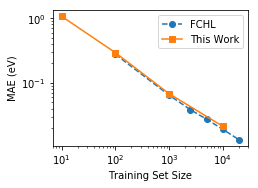

In [9]:
fig, ax = plt.subplots()

ax.loglog(jcp_results['size'], jcp_results['mae'], 'o--', label='FCHL')
ax.loglog(results['size'], results['mae'], 's-', label='This Work')

fig.set_size_inches(3.5, 2.5)
ax.legend()
ax.set_xlabel('Training Set Size')
ax.set_ylabel('MAE (eV)')

*Finding*: We are only slightly worse than the JCP paper

## Save the Model for Later Use
We are going to be retraining it on G4MP2 Energies and the Delta Learning

In [10]:
with gzip.open('fchl-model.pkl.gz', 'wb') as fp:
    pkl.dump(model, fp)